In [2]:
import math, collections
import matplotlib.pyplot as plt
import matplotlib.path
from shapely.geometry import Polygon
import numpy as np

# Create a simple polygon
hat = np.array([
    [0, 1], [0.5, 0], [2.5, 0], [3, 1], [4.5, 0],
    [6, 1], [5.5, 2], [4.5, 2], [4.5, 4], [3, 5],
    [2.5, 4], [1.5, 4], [1.5, 2],
])
hat -= [3, 1]
hat *= 0.999

def draw(polygons, red_polygons=[]):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw grid
    ax.set_xticks(np.arange(-10, 10, 1.0))
    ax.set_yticks(np.arange(-10, 10, 1.0))
    ax.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)

    # Plot polygon
    for (color_outline, color_inside, fill_alpha, polygon_list) in [
        ("blue", "skyblue", 0.4, polygons),
        ("red", "red", 0.0, red_polygons),
    ]:
        for polygon in polygon_list:
            polygon_closed = np.vstack([polygon, polygon[0]])  # Close the polygon
            ax.plot(polygon_closed[:,0], polygon_closed[:,1], color=color_outline, linewidth=2)
            ax.fill(polygon_closed[:,0], polygon_closed[:,1], color=color_inside, alpha=fill_alpha)
        
    ax.invert_yaxis()
    ax.set_aspect('equal')

    # Show plot
    plt.show()

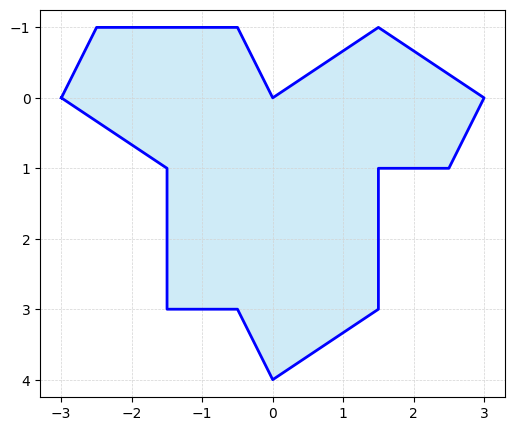

In [3]:
draw([hat])

In [4]:
def polygon_contains(a: np.ndarray, b: np.ndarray) -> bool:
    return Polygon(a).intersects(Polygon(b))

In [5]:
polygon_contains(hat, hat)

True

In [6]:
def apply_isometry(polygon: np.ndarray, n: int) -> np.ndarray:
    assert 0 <= n < 12
    polygon = polygon.copy()
    if n >= 6:
        polygon *= [-1, 1]
    angle = (n % 6) * 2 * math.pi / 6
#     polygon *= [2/3**0.5, 1]
    s, c = math.sin(angle), math.cos(angle)
    polygon = polygon @ [[c, -s], [s, c]]
#     polygon /= [2/3**0.5, 1]
    return polygon

In [7]:
def make_polygon(dx, dy, n: int) -> np.ndarray:
    poly = hat.copy()
    poly *= [2/3**0.5, 1]
    poly = apply_isometry(poly, n)
    poly /= [2/3**0.5, 1]
    poly += [dx, dy]
    return poly

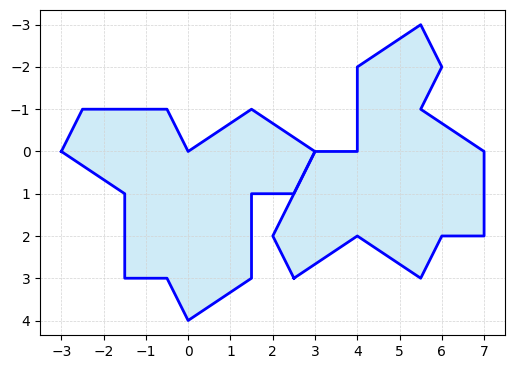

In [8]:
draw([make_polygon(0, 0, 0), make_polygon(4, 0, 1)])

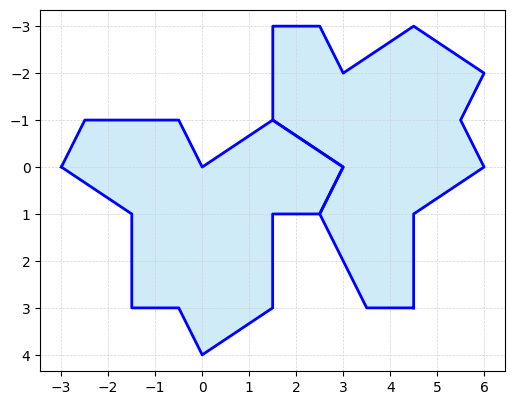

In [9]:
squishy = hat.copy()
squishy *= [2/3**0.5, 1]
squishy = apply_isometry(squishy, 2)
squishy /= [2/3**0.5, 1]
draw([hat, squishy + np.array([3, 0])])

In [10]:
from pysat.formula import CNF
from pysat.solvers import Solver

In [53]:
%%time

var_counter = 0

var_to_state = {}
for dx in range(10):
    for dy in range(10):
        for iso in range(12):
            var_counter += 1
            new_var = var_counter
            new_poly = make_polygon(dx, dy, iso)
            var_to_state[new_var] = 0.5 * dx, 0.5 * dy, iso, new_poly 

var_to_square = {}
grid_offset = 1.0, 1.0
grid_size = 8, 8
grid_square_size = 0.5
for dx in range(grid_size[0]):
    for dy in range(grid_size[1]):
        var_counter += 1
        new_var = var_counter
        new_poly = (np.array([
            [0.01, 0.01], [0.99, 0.01], [0.99, 0.99], [0.01, 0.99],
        ]) + [dx, dy]) * grid_square_size + grid_offset
        var_to_square[new_var] = dx, dy, new_poly

base_clauses = []
all_pairs = list(var_to_state.items())
for i, (var_a, (_, _, _, poly_a)) in enumerate(all_pairs):
    for var_b, (_, _, _, poly_b) in all_pairs[:i]:
        if polygon_contains(poly_a, poly_b):
            base_clauses.append([-var_a, -var_b])

guys_who_intersect_this_square = collections.defaultdict(list)
for placement_var, (_, _, _, polygon) in var_to_state.items():
    for filled_var, (_, _, square) in var_to_square.items():
        if polygon_contains(polygon, square):
            guys_who_intersect_this_square[filled_var].append(placement_var)
            base_clauses.append([-placement_var, filled_var])
guys_who_intersect_this_square = dict(guys_who_intersect_this_square)

for filled_var, placement_var_list in guys_who_intersect_this_square.items():
    base_clauses.append([-filled_var] + placement_var_list)
    
for filled_var in var_to_square:
    if filled_var not in guys_who_intersect_this_square:
        raise ValueError(f"Impossible: square {filled_var} hit by no hats!")

CPU times: user 14.8 s, sys: 19.4 ms, total: 14.8 s
Wall time: 14.9 s


In [54]:
clauses = base_clauses.copy()
for filled_var in var_to_square:
    clauses.append([filled_var])

Selected: [12, 55, 243, 460, 608, 769, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264]


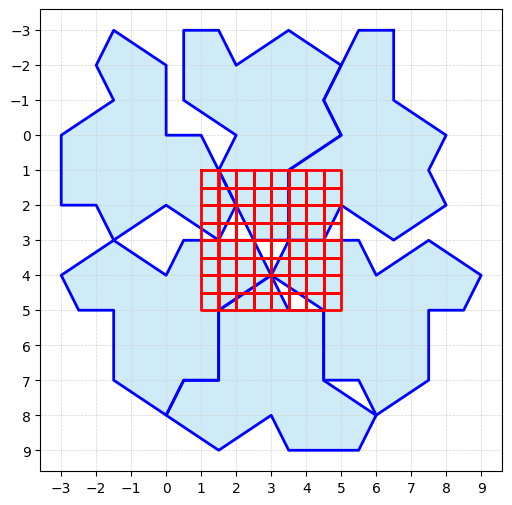

In [55]:
cnf = CNF(from_clauses=clauses)
with Solver(bootstrap_with=cnf) as solver:
    assert solver.solve(), "Not satisfiable!"
    model = [x for x in solver.get_model() if x > 0]
    print("Selected:", model)
draw(
    [
        var_to_state[var][-1] for var in model
        if var in var_to_state
    ],
    [
        var_to_square[var][-1] for var in model
        if var in var_to_square
    ],
)

In [19]:
guys_who_intersect_this_square.keys()

dict_keys([433, 434, 437, 438, 435, 439, 436, 440, 441, 442, 443, 444, 445, 446, 447, 448])

In [20]:
placed_hats = [var for var in model if var in var_to_state]

In [21]:
placed_hats

[37, 292, 344]

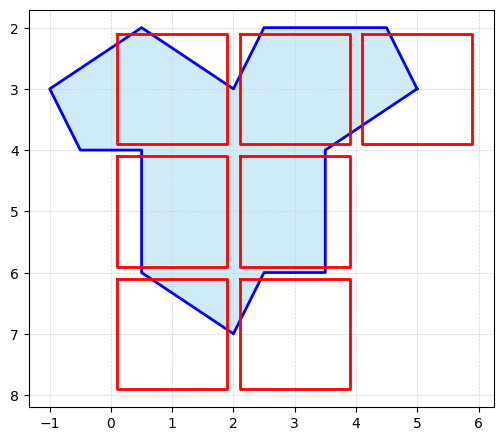

In [22]:
# Let's check which squares are covered by a given hat.
hat_var = 187
hit_squares = []
for square_var, placement_vars in guys_who_intersect_this_square.items():
    if hat_var in placement_vars:
        hit_squares.append(var_to_square[square_var][-1])
draw([var_to_state[hat_var][-1]], hit_squares)